In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

Using TensorFlow backend.


Actual
[[0.00071864]
 [0.01803382]
 [0.11465593]
 [0.1213861 ]
 [0.1712333 ]]
Pred
[[0.0014995 ]
 [0.01881927]
 [0.11527675]
 [0.12211564]
 [0.17262527]]


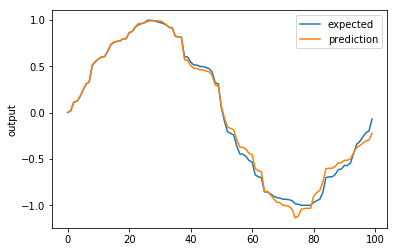

In [2]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.sin(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,batch_size=len(x),epochs=25000)

pred = model.predict(x)

print("Actual")
print(y[0:5])

print("Pred")
print(pred[0:5])

chart_regression(pred.flatten(),y,sort=False)

In [3]:
from sklearn import metrics

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.pi * np.sin(x*(np.pi/180.0)).ravel(), np.pi * np.cos(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(2)) # Two output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,batch_size=len(x),epochs=25000)


# Fit regression DNN model.
pred = model.predict(x)

score = np.sqrt(metrics.mean_squared_error(pred, y))
print("Score (RMSE): {}".format(score))

np.set_printoptions(suppress=True)

print("Predicted:")
print(np.array(pred[20:25]))

print("Expected:")
print(np.array(y[20:25]))

Score (RMSE): 0.11337800896167427
Predicted:
[[2.7009873 1.580196 ]
 [2.7355504 1.4975029]
 [2.8616257 1.1934081]
 [2.9524908 0.974239 ]
 [3.001223  0.8566929]]
Expected:
[[2.70765313 1.59317888]
 [2.75138445 1.51640628]
 [2.89299999 1.22480835]
 [2.97603942 1.00637655]
 [3.01381723 0.88685404]]
